## Load datasets

In [49]:
import pandas as pd
import os

dfs_train = {}
dfs_val = {}
for file in os.listdir("vectorized_data"):
    if file.endswith("train.csv"):
        df = pd.read_csv("vectorized_data/" + file, index_col=0)
        key = file.split("_")[-2]
        dfs_train[key] = df
    elif file.endswith("val.csv"):
        df = pd.read_csv("vectorized_data/" + file, index_col=0)
        key = file.split("_")[-2]
        dfs_val[key] = df

for key in dfs_train:
    dfs_train[key] = {
        'label': dfs_train[key]["category1"],
        'data': dfs_train[key].drop(columns=["category1"])
    }

    print(f"DFs train {key} (data):{dfs_train[key]['data'].shape}")

for key in dfs_val:
    dfs_val[key] = {
        'label': dfs_val[key]["category1"],
        'data': dfs_val[key].drop(columns=["category1"])
    }

    print(f"DFs validation {key} (data):{dfs_val[key]['data'].shape}")

DFs train 0.025 (data):(15557, 138)
DFs train 0.05 (data):(15557, 54)
DFs train 0.01 (data):(15557, 377)
DFs train 0.1 (data):(15557, 19)
DFs train 0.075 (data):(15557, 30)
DFs validation 0.01 (data):(15556, 377)
DFs validation 0.05 (data):(15556, 54)
DFs validation 0.025 (data):(15556, 138)
DFs validation 0.1 (data):(15556, 19)
DFs validation 0.075 (data):(15556, 30)


## Evaluate accuracy with k-NN

### Determine best vectorizer min_df value

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_classification_single(knn, data, data_class):
    y_pred = knn.predict(data)
    return accuracy_score(data_class, y_pred)

def evaluate_classification_dataset(df_train, df_val, n_neighbors):
    accuracy_train = []
    accuracy_val = []
    for k in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(df_train['data'], df_train['label'])
        accuracy_train.append(evaluate_classification_single(knn, df_train['data'], df_train['label']))
        accuracy_val.append(evaluate_classification_single(knn, df_val['data'], df_val['label']))
    return accuracy_train, accuracy_val



In [51]:
n_neighbors = [2, 5, 10, 15, 20, 25]
# n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = {}

for key in dfs_train:
    print(f'Evaluating dataset {key}')
    acc_train, acc_val = evaluate_classification_dataset(dfs_train[key], dfs_val[key], n_neighbors)
    accuracies[key] = {
        'train': acc_train,
        'val': acc_val
    }
    # print(f'--> Accuracy lengths ({key}): \n {len(acc_train)}\n {len(acc_val)}')

Evaluating dataset 0.025
Evaluating dataset 0.05
Evaluating dataset 0.01
Evaluating dataset 0.1
Evaluating dataset 0.075


In [52]:
def plot_accuracy(accuracies, n_neighbors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    for key in accuracies:
        plt.subplot(1, 2, 1)
        plt.plot(n_neighbors, accuracies[key]['train'], label=f'Train {key}')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Accuracy')
        plt.title('Train Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(n_neighbors, accuracies[key]['val'], label=f'Validation {key}')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

    plt.show()

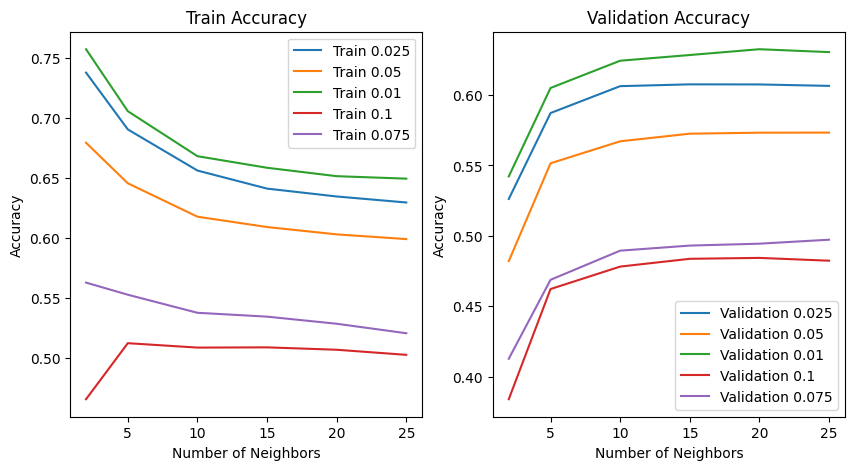

In [53]:
plot_accuracy(accuracies, n_neighbors)

### Create reduced datasets

In [54]:
# Based on the plot, we can see that the best value for min_df is:
min_df_val = '0.01'

In [55]:
data = dfs_train[min_df_val]
data['label'].value_counts()

category1
Equipamentos de informática (falha/substituição/instalação/configuração)    5074
Habilitação/Acesso a sistemas                                               4417
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)    2793
Conexão de dados/rede                                                       1293
Equipamentos de microinformática                                             570
Redes e conectividade de dados                                               288
Sistemas e serviços                                                          281
Dúvidas, informações e orientações                                           239
Portal/Internet/Intranet (configuração/falha/dúvidas)                        145
Informação eleitoral (relatórios/consultas/dúvidas)                          142
Suporte presencial a eventos                                                  85
Suporte remoto a eventos                                                      50
Incidente de Segur

### K-Nearest Neighbors (KNN) ###
Acurácia: 0.5782
Recall (weighted): 0.5782
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

                                             Central de Atendimento STIE       0.25      0.22      0.24         9
                                                   Conexão de dados/rede       0.42      0.41      0.41      1321
                                      Dúvidas, informações e orientações       0.52      0.33      0.41       241
Equipamentos de informática (falha/substituição/instalação/configuração)       0.69      0.74      0.71      5094
                                        Equipamentos de microinformática       0.39      0.13      0.19       597
                                           Habilitação/Acesso a sistemas       0.55      0.77      0.64      4303
                                    Incidente de Segurança da Informação       0.00      0.00   

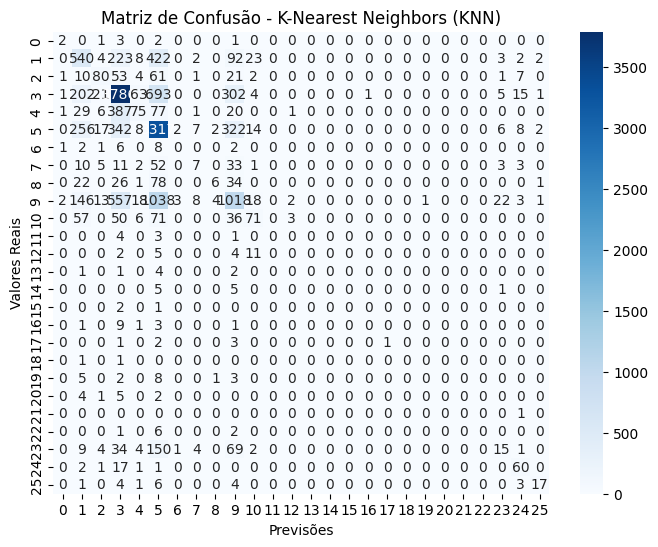

### Random Forest ###
Acurácia: 0.6633
Recall (weighted): 0.6633
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

                                             Central de Atendimento STIE       0.50      0.11      0.18         9
                                                   Conexão de dados/rede       0.63      0.36      0.46      1321
                                      Dúvidas, informações e orientações       0.85      0.34      0.49       241
Equipamentos de informática (falha/substituição/instalação/configuração)       0.71      0.85      0.77      5094
                                        Equipamentos de microinformática       0.56      0.13      0.20       597
                                           Habilitação/Acesso a sistemas       0.69      0.81      0.74      4303
                                    Incidente de Segurança da Informação       1.00      0.00      0.00     

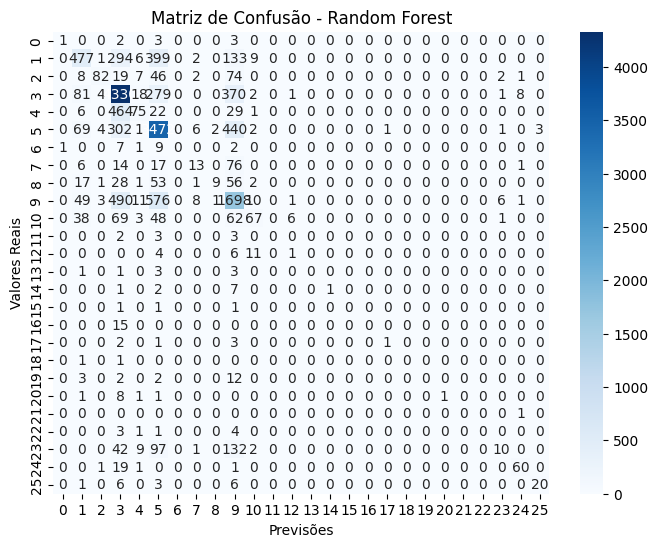

In [56]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
train_data = dfs_train[min_df_val]
val_data = dfs_val[min_df_val]

# Separar features (X) e labels (y) dos dados de treino e validação
X_train = train_data['data']
y_train = train_data['label']

X_val = val_data['data']
y_val = val_data['label']

def avaliar_modelo(nome_modelo, modelo, X_val, y_val):
    # Fazer previsões
    y_pred = modelo.predict(X_val)
    
    # Calcular métricas
    acuracia = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)  # Ajuste conforme a natureza dos dados
    matriz_confusao = confusion_matrix(y_val, y_pred)
    
    # Exibir métricas
    print(f"### {nome_modelo} ###")
    print(f"Acurácia: {acuracia:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print("Relatório de Classificação:")
    print(classification_report(y_val, y_pred, zero_division=1))
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.xlabel('Previsões')
    plt.ylabel('Valores Reais')
    plt.show()

# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Avaliar o modelo KNN
avaliar_modelo("K-Nearest Neighbors (KNN)", knn, X_val, y_val)

# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Avaliar o modelo Random Forest
avaliar_modelo("Random Forest", rf, X_val, y_val)

In [57]:
def generate_new_labels(old_labels):
    labels = [
        "Equipamentos de informática (falha/substituição/instalação/configuração)",
        "Habilitação/Acesso a sistemas",
        "Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)"
        ]
    new_labels = []
    for y in old_labels:
        if y not in labels:
            new_labels.append("Outros")
        else:
            new_labels.append(y)
    return new_labels
new_labels_train = generate_new_labels(y_train)
new_labels_val = generate_new_labels(y_val)
new_labels_train = pd.Series(new_labels_train, name='category1')
new_labels_val = pd.Series(new_labels_val, name='category1')
new_labels_train.value_counts()

category1
Equipamentos de informática (falha/substituição/instalação/configuração)    5074
Habilitação/Acesso a sistemas                                               4417
Outros                                                                      3273
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)    2793
Name: count, dtype: int64

### K-Nearest Neighbors (KNN) ###
Acurácia: 0.5979
Recall (weighted): 0.5979
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.69      0.74      0.71      5094
                                           Habilitação/Acesso a sistemas       0.55      0.78      0.64      4303
                                                                  Outros       0.56      0.38      0.46      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.54      0.32      0.40      2854

                                                                accuracy                           0.60     15556
                                                               macro avg       0.58      0.56      0.55     15556
                                                            weighted avg       0.59      0.60  

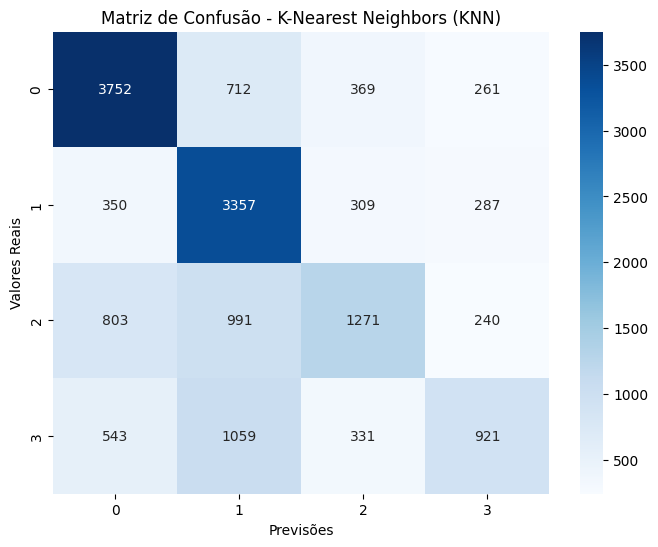

### Random Forest ###
Acurácia: 0.6837
Recall (weighted): 0.6837
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.74      0.83      0.78      5094
                                           Habilitação/Acesso a sistemas       0.71      0.79      0.75      4303
                                                                  Outros       0.63      0.45      0.52      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.57      0.54      0.55      2854

                                                                accuracy                           0.68     15556
                                                               macro avg       0.66      0.65      0.65     15556
                                                            weighted avg       0.68      0.68      0.68    

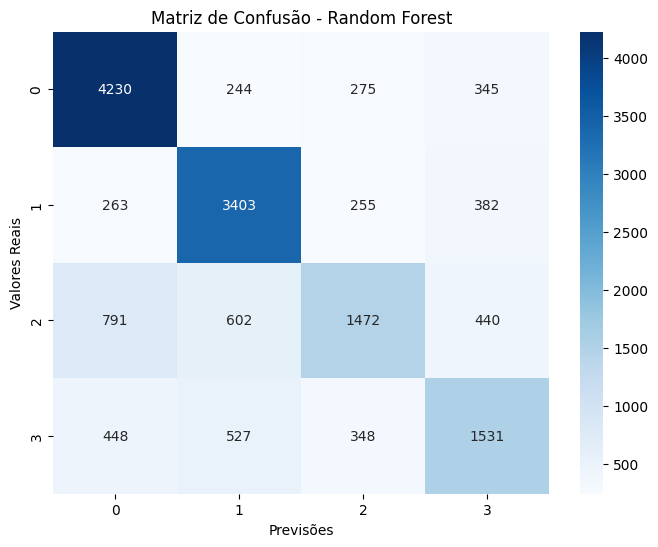

In [58]:
# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, new_labels_train)

# Avaliar o modelo KNN
avaliar_modelo("K-Nearest Neighbors (KNN)", knn, X_val, new_labels_val)

# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, new_labels_train)

# Avaliar o modelo Random Forest
avaliar_modelo("Random Forest", rf, X_val, new_labels_val)

In [61]:
from imblearn.over_sampling import SMOTE

over_sample_params = {
    "Equipamentos de informática (falha/substituição/instalação/configuração)": 5074,
    "Habilitação/Acesso a sistemas": 5074,
    "Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)": 5074,
    "Outros": 5074
}

# Aplicar a técnica SMOTE
smote = SMOTE(sampling_strategy=over_sample_params)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, new_labels_train)
y_train_resampled.value_counts()

category1
Habilitação/Acesso a sistemas                                               5074
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)    5074
Equipamentos de informática (falha/substituição/instalação/configuração)    5074
Outros                                                                      5074
Name: count, dtype: int64

### K-Nearest Neighbors (KNN) ###
Acurácia: 0.5339
Recall (weighted): 0.5339
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.75      0.51      0.61      5094
                                           Habilitação/Acesso a sistemas       0.69      0.54      0.61      4303
                                                                  Outros       0.40      0.54      0.46      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.38      0.56      0.45      2854

                                                                accuracy                           0.53     15556
                                                               macro avg       0.55      0.54      0.53     15556
                                                            weighted avg       0.59      0.53  

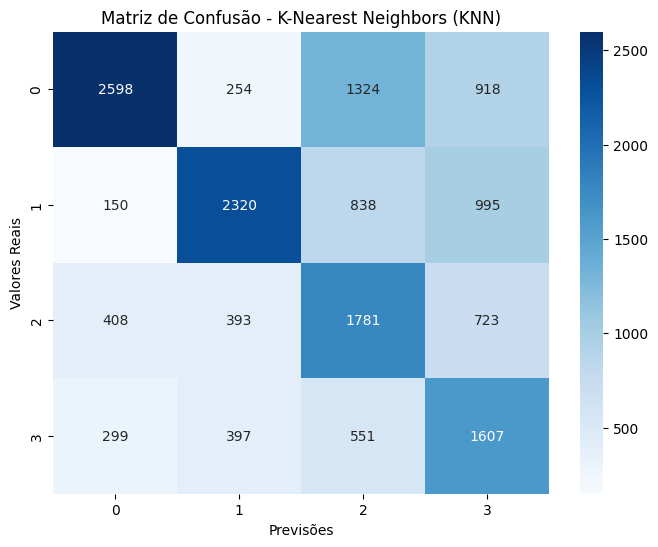

### Random Forest ###
Acurácia: 0.6845
Recall (weighted): 0.6845
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.76      0.80      0.78      5094
                                           Habilitação/Acesso a sistemas       0.73      0.76      0.75      4303
                                                                  Outros       0.61      0.49      0.54      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.54      0.59      0.57      2854

                                                                accuracy                           0.68     15556
                                                               macro avg       0.66      0.66      0.66     15556
                                                            weighted avg       0.68      0.68      0.68    

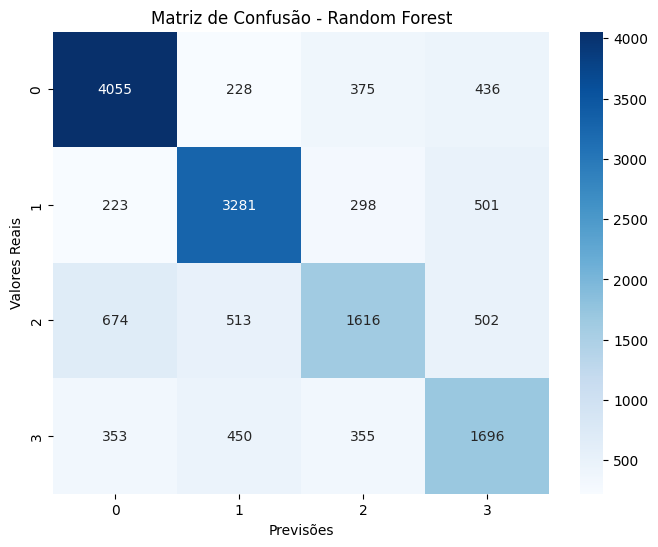

In [62]:
# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)

# Avaliar o modelo KNN
avaliar_modelo("K-Nearest Neighbors (KNN)", knn, X_val, new_labels_val)

# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Avaliar o modelo Random Forest
avaliar_modelo("Random Forest", rf, X_val, new_labels_val)

In [66]:
from imblearn.under_sampling import RandomUnderSampler

down_sample_params = {
    "Equipamentos de informática (falha/substituição/instalação/configuração)": 2793,
    "Habilitação/Acesso a sistemas": 2793,
    "Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)": 2793,
    "Outros": 2793
}

# Inicializar o undersampler
rus = RandomUnderSampler(sampling_strategy=down_sample_params)

# Aplicar o undersampling nos dados de treino
X_resampled, y_resampled = rus.fit_resample(X_train, new_labels_train)

# Verificar a nova contagem de itens em cada classe após o undersampling
print("Contagem de itens em cada label após undersampling (Random Undersampler):")
print(pd.Series(y_resampled).value_counts())

Contagem de itens em cada label após undersampling (Random Undersampler):
category1
Equipamentos de informática (falha/substituição/instalação/configuração)    2793
Habilitação/Acesso a sistemas                                               2793
Outros                                                                      2793
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)    2793
Name: count, dtype: int64


### K-Nearest Neighbors (KNN) ###
Acurácia: 0.5717
Recall (weighted): 0.5717
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.55      0.79      0.65      5094
                                           Habilitação/Acesso a sistemas       0.69      0.59      0.63      4303
                                                                  Outros       0.52      0.39      0.45      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.50      0.36      0.42      2854

                                                                accuracy                           0.57     15556
                                                               macro avg       0.56      0.53      0.54     15556
                                                            weighted avg       0.57      0.57  

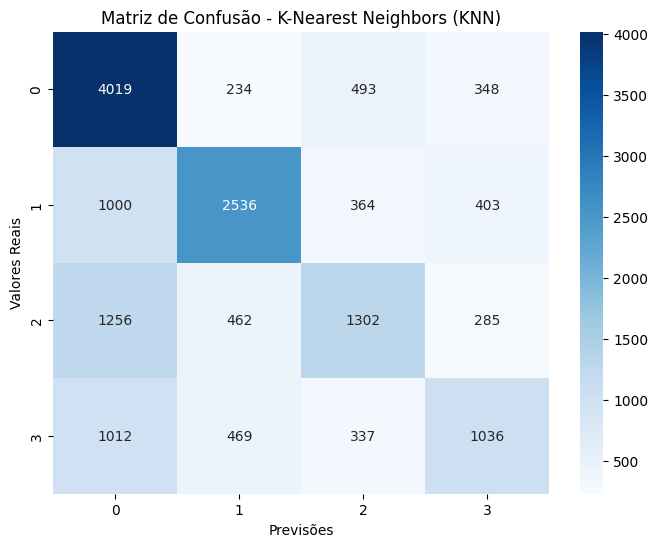

### Random Forest ###
Acurácia: 0.6733
Recall (weighted): 0.6733
Relatório de Classificação:
                                                                          precision    recall  f1-score   support

Equipamentos de informática (falha/substituição/instalação/configuração)       0.79      0.75      0.77      5094
                                           Habilitação/Acesso a sistemas       0.75      0.73      0.74      4303
                                                                  Outros       0.58      0.50      0.54      3305
Programa/Sistema (instalação/configuração/erros/dúvidas/desenvolvimento)       0.51      0.65      0.57      2854

                                                                accuracy                           0.67     15556
                                                               macro avg       0.66      0.66      0.65     15556
                                                            weighted avg       0.68      0.67      0.68    

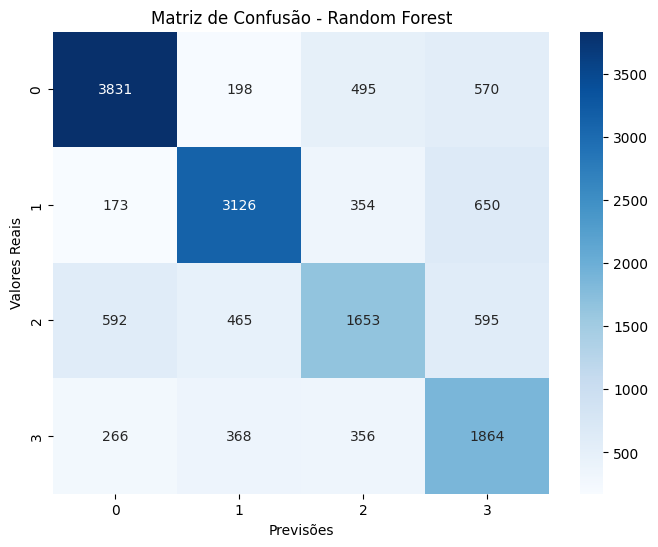

In [67]:
# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_resampled, y_resampled)

# Avaliar o modelo KNN
avaliar_modelo("K-Nearest Neighbors (KNN)", knn, X_val, new_labels_val)

# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# Avaliar o modelo Random Forest
avaliar_modelo("Random Forest", rf, X_val, new_labels_val)